In [2]:
import pandas as pd

In [3]:
week1 = pd.read_csv("voronoi1.csv")
week2 = pd.read_csv("voronoi2.csv")
week3 = pd.read_csv("voronoi3.csv")
week4 = pd.read_csv("voronoi4.csv")
week5 = pd.read_csv("voronoi5.csv")
week6 = pd.read_csv("voronoi6.csv")
week7 = pd.read_csv("voronoi7.csv")
week9 = pd.read_csv("voronoi9.csv")

In [4]:
week1

,Unnamed: 0,gameId,playId,routeRunnerId,maxValueOfSeparation,frameId,timeSinceSnap,timeToThrow,yardsDownField
0,0,2022090800,56,42489.0,79.994444,157,1.1,2.169,1.17
1,1,2022090800,56,44985.0,67.031035,167,2.1,2.169,6.32
2,2,2022090800,56,47857.0,23.841223,167,2.1,2.169,-3.79
3,3,2022090800,56,47879.0,36.711539,161,1.5,2.169,3.11
4,4,2022090800,56,52536.0,83.792040,157,1.1,2.169,1.22
...,...,...,...,...,...,...,...,...,...
2325,2325,2022091200,3723,46109.0,148.752333,337,2.7,2.717,7.28
2326,2326,2022091200,3723,52423.0,131.725928,337,2.7,2.717,4.39
2327,2327,2022091200,3723,52454.0,65.682032,321,1.1,2.717,-0.14
2328,2328,2022091200,3723,52526.0,43.825016,327,1.7,2.717,4.21


In [5]:
dfs = [week1,week2,week3,week4,week5,week6,week7,week9]
final_df = pd.concat(dfs, ignore_index=True)
voronoi_df = final_df[['gameId','playId','routeRunnerId','maxValueOfSeparation']]

In [6]:
df = pd.read_csv("allVoronoi.csv")

In [46]:
voronoi_df

,gameId,playId,routeRunnerId,maxValueOfSeparation
0,2022090800,56,42489.0,79.994444
1,2022090800,56,44985.0,67.031035
2,2022090800,56,47857.0,23.841223
3,2022090800,56,47879.0,36.711539
4,2022090800,56,52536.0,83.792040
...,...,...,...,...
12910,2022110700,3059,43415.0,102.978926
12911,2022110700,3059,47896.0,13.723434
12912,2022110700,3059,52500.0,61.155149
12913,2022110700,3059,52609.0,47.040948


In [7]:
df = df.iloc[:,1:]

In [8]:
df = pd.merge(
    df,
    voronoi_df,
    how ="left",
    left_on=['gameId','playId','nflId'],
    right_on = ['gameId','playId','routeRunnerId']
)

,gameId,playId,nflId,motionSinceLineset,inMotionAtBallSnap,wasRunningRoute,wasTargettedReceiver,down,yardsToGo,offenseFormation,...,absoluteYardlineNumber,y,topOfLine,bottomOfLine,position,safetyTop,safetyBottom,routeRunnerId,maxValueOfSeparation,routeRan
0,2022090800,56,42489,True,False,1.0,1,1,10,SHOTGUN,...,85,43.65,32.87,26.35,WR,1.0,2.0,42489.0,79.994444,IN
1,2022090800,569,42489,True,True,1.0,1,3,4,SHOTGUN,...,95,34.99,32.57,25.86,WR,1.0,1.0,42489.0,61.481439,IN
2,2022090800,617,42489,False,False,1.0,0,1,10,SHOTGUN,...,74,34.55,26.68,20.30,WR,2.0,1.0,42489.0,96.594904,GO
3,2022090800,1030,42489,False,False,1.0,0,3,2,SHOTGUN,...,50,9.36,27.25,20.58,WR,0.0,2.0,42489.0,63.326578,HITCH
4,2022090800,2184,42489,True,False,1.0,1,1,10,SHOTGUN,...,32,8.17,26.62,20.12,WR,1.0,1.0,42489.0,84.490809,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11362,2022110605,2628,46238,True,False,1.0,0,1,10,SHOTGUN,...,86,21.54,26.93,20.40,RB,2.0,1.0,46238.0,35.580046,FLAT
11363,2022110605,2657,46238,False,False,1.0,0,2,8,SHOTGUN,...,84,32.39,32.74,26.32,RB,1.0,1.0,46238.0,79.596768,FLAT
11364,2022110605,2681,46238,True,False,1.0,0,3,3,SHOTGUN,...,79,31.96,32.86,26.47,RB,2.0,0.0,46238.0,84.133955,FLAT
11365,2022110605,3434,52488,True,True,1.0,0,2,10,SINGLEBACK,...,64,37.93,32.89,26.65,WR,1.0,1.0,52488.0,58.235303,GO


In [9]:
df[(df['gameId']==2022090800)&(df['playId']==550)]

,gameId,playId,nflId,motionSinceLineset,inMotionAtBallSnap,wasRunningRoute,wasTargettedReceiver,down,yardsToGo,offenseFormation,...,absoluteYardlineNumber,y,topOfLine,bottomOfLine,position,Unnamed: 0,safetyTop,safetyBottom,routeRunnerId,maxValueOfSeparation
1,2022090800,550,42489,True,True,1.0,0,2,3,SHOTGUN,...,94,38.71,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
100,2022090800,550,44985,False,False,1.0,0,2,3,SHOTGUN,...,94,18.32,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
159,2022090800,550,47879,False,False,1.0,0,2,3,SHOTGUN,...,94,34.35,32.51,25.85,TE,1854.0,1.0,1.0,NaN,NaN
233,2022090800,550,52536,False,False,1.0,0,2,3,SHOTGUN,...,94,11.33,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
706,2022090800,550,47857,False,False,1.0,0,2,3,SHOTGUN,...,94,32.26,32.51,25.85,RB,1854.0,1.0,1.0,NaN,NaN


In [10]:
df = df.dropna()

In [11]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
playerplays = pd.read_csv('player_play.csv')

In [13]:
df = pd.merge(
    df,
    playerplays[['gameId','playId','nflId','routeRan']],
    how = "left",
    on=['gameId','playId','nflId']
)

In [51]:
one = pd.DataFrame(columns=[
    'gameId', 'playId', 'down', 'yardsToGo', 'offenseFormation', 
    'pff_passCoverage', 'absoluteYardlineNumber', 'receiverAlignment',
    'firstY', 'secondY', 'thirdY', 'fourthY', 'fifthY', 'sixthY', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute','safetyTop','safetyBottom', 'rbPosition',
    'aboveLine', 'belowLine','motionReceiver', 'motionCluster', 'inMotionAtBallSnap', 
    'targetedReceiver', 'maxSeparationReceiver', 'secondMaxSeparationRec', 'nflId'
])

for _, i in df.iterrows():
    inone = ((one['gameId'] == i['gameId']) & (one['playId'] == i['playId'])).any()
    
    if not inone:
        play = df[(df['gameId'] == i['gameId']) & 
                       (df['playId'] == i['playId'])]
        play = play.sort_values(by='y', ascending=False)
        motion_players = play[play['motionSinceLineset']]  # Get motion players

        for _, motion_player in motion_players.iterrows():
            thisplay = [
                i['gameId'],
                i['playId'],
                i['down'], 
                i['yardsToGo'], 
                i['offenseFormation'],
                i['pff_passCoverage'], 
                i['absoluteYardlineNumber'],
                i['receiverAlignment']
            ]

            motionrec = 0
            targetrec = 0
            motionindex = 1
            targetindex = 1
            aboveline = 0
            belowline = 0
            moving = False
            rbindex = 0
            maxseparationrec = 0
            secondmaxseparationrec = 0
            max = 0
            second_max = 0

            for _, j in play.iterrows():
                thisplay.append(j['y'])
                if j['y'] > j['topOfLine']:
                    aboveline += 1
                elif j['y'] < j['bottomOfLine']:
                    belowline += 1
                if j['motionSinceLineset']:
                    if j['nflId'] == motion_player['nflId']:  # Focus on specific motion player
                        motionrec = motionindex
                        if j['inMotionAtBallSnap']:
                            moving = True
                if j['position'] == 'RB':
                    rbindex = targetindex
                if j['wasTargettedReceiver']:
                    targetrec = targetindex
                if j['maxValueOfSeparation'] > max:
                    second_max = max
                    secondmaxseparationrec = maxseparationrec
                    max = j['maxValueOfSeparation']
                    maxseparationrec = targetindex
                elif max - 5 < j['maxValueOfSeparation'] <= max and j['maxValueOfSeparation'] > second_max:
                    second_max = j['maxValueOfSeparation']
                    secondmaxseparationrec = targetindex
                motionindex += 1
                targetindex += 1
            
            while len(thisplay) < 14:
                thisplay.append(0)
            
            for _, j in play.iterrows():
                thisplay.append(j['routeRan'])

            while len(thisplay) < 19:
                thisplay.append(0)

            thisplay.extend([
                i['safetyTop'],
                i['safetyBottom'],
                rbindex,
                aboveline,
                belowline,
                motionrec,
                0,  # Add motion cluster
                moving,
                targetrec,
                maxseparationrec,  # Max separation receiver
                secondmaxseparationrec,  # Second max separation receiver
                motion_player['nflId']
            ])
            
            new_row = pd.DataFrame([thisplay], columns=one.columns)
            one = pd.concat([one, new_row], ignore_index=True)


C:\Users\rschw\AppData\Local\Temp\ipykernel_3308\3021457737.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one = pd.concat([one, new_row], ignore_index=True)


In [54]:
one

,gameId,playId,down,yardsToGo,offenseFormation,pff_passCoverage,absoluteYardlineNumber,receiverAlignment,firstY,secondY,...,rbPosition,aboveLine,belowLine,motionReceiver,motionCluster,inMotionAtBallSnap,targetedReceiver,maxSeparationReceiver,secondMaxSeparationRec,nflId
0,2022090800,56,1,10,SHOTGUN,Cover 6-Left,85,2x2,43.65,34.37,...,0,2,2,1,0,False,1,4,1,42489
1,2022090800,569,3,4,SHOTGUN,Cover-3,95,2x2,34.99,34.61,...,3,2,2,1,0,True,1,5,1,42489
2,2022090800,617,1,10,SHOTGUN,Cover-3,74,2x1,34.55,25.55,...,0,1,1,3,0,True,3,1,0,44985
3,2022090800,1030,3,2,SHOTGUN,Cover-3,50,2x2,42.03,26.77,...,3,1,2,2,0,True,1,1,0,44985
4,2022090800,2184,1,10,SHOTGUN,Cover-3 Seam,32,2x2,43.64,34.90,...,3,2,2,5,0,False,5,1,5,42489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,2022100910,1714,3,10,SHOTGUN,Cover-2,80,2x2,19.52,0.00,...,0,0,1,1,0,False,1,1,0,44959
3054,2022102310,3273,1,10,SINGLEBACK,Cover 6-Left,64,2x2,19.16,0.00,...,0,0,1,1,0,False,1,1,0,44959
3055,2022100203,3470,2,9,SHOTGUN,Quarters,80,2x2,34.43,0.00,...,0,1,0,1,0,False,1,1,0,54520
3056,2022102307,3262,2,8,SHOTGUN,Quarters,37,2x2,35.06,0.00,...,0,1,0,1,0,False,1,1,0,54545


In [55]:
one = one[one['thirdY']!=0]

In [56]:
one.iloc[:,8:19]

,firstY,secondY,thirdY,fourthY,fifthY,sixthY,firstRoute,secondRoute,thirdRoute,fourthRoute,fifthRoute
0,43.65,34.37,18.20,8.25,0,0,IN,IN,OUT,GO,0
1,34.99,34.61,26.97,18.19,10.38,0,IN,CROSS,FLAT,GO,GO
2,34.55,25.55,21.53,14.89,0,0,GO,FLAT,GO,IN,0
3,42.03,26.77,26.19,18.16,9.36,0,HITCH,FLAT,ANGLE,GO,HITCH
4,43.64,34.90,26.09,17.15,8.17,0,GO,OUT,FLAT,IN,HITCH
...,...,...,...,...,...,...,...,...,...,...,...
3031,38.03,35.65,30.28,21.88,16.64,0,GO,CROSS,POST,FLAT,CROSS
3032,43.95,35.12,31.33,21.79,9.23,0,POST,CROSS,SLANT,FLAT,GO
3033,33.99,29.91,23.98,21.94,0,0,CORNER,FLAT,CROSS,CROSS,0
3034,42.48,30.85,26.46,16.43,10.69,0,GO,HITCH,ANGLE,HITCH,HITCH


In [57]:
one['maxSeparationReceiver'].value_counts()

maxSeparationReceiver
1    858
5    578
4    516
2    489
3    417
Name: count, dtype: int64

In [58]:
one

,gameId,playId,down,yardsToGo,offenseFormation,pff_passCoverage,absoluteYardlineNumber,receiverAlignment,firstY,secondY,...,rbPosition,aboveLine,belowLine,motionReceiver,motionCluster,inMotionAtBallSnap,targetedReceiver,maxSeparationReceiver,secondMaxSeparationRec,nflId
0,2022090800,56,1,10,SHOTGUN,Cover 6-Left,85,2x2,43.65,34.37,...,0,2,2,1,0,False,1,4,1,42489
1,2022090800,569,3,4,SHOTGUN,Cover-3,95,2x2,34.99,34.61,...,3,2,2,1,0,True,1,5,1,42489
2,2022090800,617,1,10,SHOTGUN,Cover-3,74,2x1,34.55,25.55,...,0,1,1,3,0,True,3,1,0,44985
3,2022090800,1030,3,2,SHOTGUN,Cover-3,50,2x2,42.03,26.77,...,3,1,2,2,0,True,1,1,0,44985
4,2022090800,2184,1,10,SHOTGUN,Cover-3 Seam,32,2x2,43.64,34.90,...,3,2,2,5,0,False,5,1,5,42489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2022102307,2333,3,6,SHOTGUN,Cover-1,67,3x1,38.03,35.65,...,4,3,1,2,0,True,5,1,0,52423
3032,2022102307,3864,4,3,SHOTGUN,Cover-1,85,3x1,43.95,35.12,...,4,3,2,3,0,False,5,5,1,54545
3033,2022091200,3216,3,2,SINGLEBACK,Cover-3,40,3x1,33.99,29.91,...,2,1,2,4,0,True,4,4,2,52423
3034,2022092513,1036,1,10,SHOTGUN,Cover-2,50,2x2,42.48,30.85,...,3,2,2,1,0,False,4,5,1,52766


In [59]:
clusters = pd.read_csv("clusters_final.csv")
clusters

,Unnamed: 0,nflId,gameId,playId,cluster
0,0,42489.0,2022090800,56,5
1,1,47857.0,2022090800,80,0
2,2,47879.0,2022090800,212,1
3,3,52536.0,2022090800,236,3
4,4,43399.0,2022090800,299,4
...,...,...,...,...,...
4630,4630,33130.0,2022110700,2182,6
4631,4631,43362.0,2022110700,2261,0
4632,4632,43362.0,2022110700,2307,0
4633,4633,44879.0,2022110700,2496,0


In [60]:
one = pd.merge(
    one,
    clusters[['gameId','playId','nflId', 'cluster']],
    how = "left",
    on = ['gameId','playId','nflId']
)

In [61]:
one['motionCluster'] = one['cluster']

In [64]:
one.columns

Index(['gameId', 'playId', 'down', 'yardsToGo', 'offenseFormation',
       'pff_passCoverage', 'absoluteYardlineNumber', 'receiverAlignment',
       'firstY', 'secondY', 'thirdY', 'fourthY', 'fifthY', 'sixthY',
       'firstRoute', 'secondRoute', 'thirdRoute', 'fourthRoute', 'fifthRoute',
       'safetyTop', 'safetyBottom', 'rbPosition', 'aboveLine', 'belowLine',
       'motionReceiver', 'motionCluster', 'inMotionAtBallSnap',
       'targetedReceiver', 'maxSeparationReceiver', 'secondMaxSeparationRec',
       'nflId', 'cluster'],
      dtype='object')

Random Forest

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [135]:
X = one.drop(columns = ['gameId','playId','nflId','targetedReceiver','maxSeparationReceiver', 'cluster', 'receiverAlignment', 'sixthY','secondMaxSeparationRec'])

In [136]:
y = one['maxSeparationReceiver']
y1 = one['secondMaxSeparationRec']

In [137]:
y = y.astype("category")
y1 = y1.astype("category")

In [138]:
X.columns

Index(['down', 'yardsToGo', 'offenseFormation', 'pff_passCoverage',
       'absoluteYardlineNumber', 'firstY', 'secondY', 'thirdY', 'fourthY',
       'fifthY', 'firstRoute', 'secondRoute', 'thirdRoute', 'fourthRoute',
       'fifthRoute', 'safetyTop', 'safetyBottom', 'rbPosition', 'aboveLine',
       'belowLine', 'motionReceiver', 'motionCluster', 'inMotionAtBallSnap'],
      dtype='object')

In [139]:
X_dummies = pd.get_dummies(X, columns=['down','rbPosition','offenseFormation','motionReceiver','motionCluster', 'pff_passCoverage', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

In [141]:
y.value_counts()

maxSeparationReceiver
1    858
5    578
4    516
2    489
3    417
Name: count, dtype: int64

In [142]:
y1.value_counts()

secondMaxSeparationRec
1    1291
0     766
2     372
3     243
4     121
5      65
Name: count, dtype: int64

In [143]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced_subsample")

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       random_state=42)

In [144]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 1.0


In [145]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.5664335664335665


In [146]:
# This is if you combine the a reciever with a close max value of seperation score

from sklearn.metrics import accuracy_score
import numpy as np

def custom_accuracy(predictions, y_true, y_true_second):
    correct_predictions = 0
    for pred, true, true_second in zip(predictions, y_true, y_true_second):
        if pred == true or pred == true_second:
            correct_predictions += 1
    return correct_predictions / len(predictions)

y_train_second, y_test_second = train_test_split(y1, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced_subsample")
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


custom_acc = custom_accuracy(y_pred, y_test, y_test_second)
print("Custom Accuracy:", custom_acc)

Custom Accuracy: 0.7255244755244755


In [149]:
feature_importances = rf.feature_importances_
important = pd.DataFrame()
for name, importance in zip(X_test, feature_importances):
    important = pd.concat([important, pd.DataFrame({'Name': [name], 'Importance': [importance]})], ignore_index=True)

important = important.sort_values(by='Importance', ascending=False)
important.head(50)

,Name,Importance
2,firstY,0.058737
5,fourthY,0.057931
3,secondY,0.055848
4,thirdY,0.055649
1,absoluteYardlineNumber,0.050222
6,fifthY,0.049302
0,yardsToGo,0.033215
111,fifthRoute_GO,0.018442
10,belowLine,0.017937
9,aboveLine,0.016356


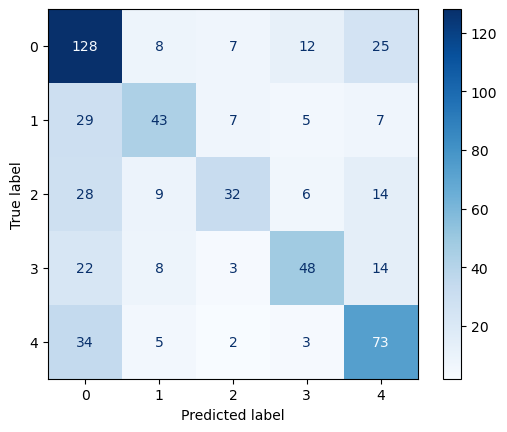

In [150]:
cm_best = confusion_matrix(y_test, rf.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [38]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced_subsample")

rf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       random_state=42)

In [39]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 1.0


In [40]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.5506993006993007


<Figure size 300x200 with 0 Axes>

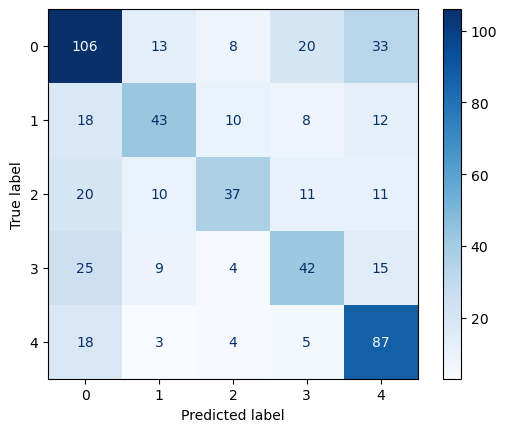

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm_best = confusion_matrix(y_test, rf.predict(X_test))

# Set a smaller figure size
plt.figure(figsize=(3, 2))  # Adjust the width and height (in inches)

# Create and plot the confusion matrix display
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')  # Use the current axis for consistency

# Save the smaller plot
plt.savefig('confusion_matrix_small.png', dpi=300)  # Save before showing



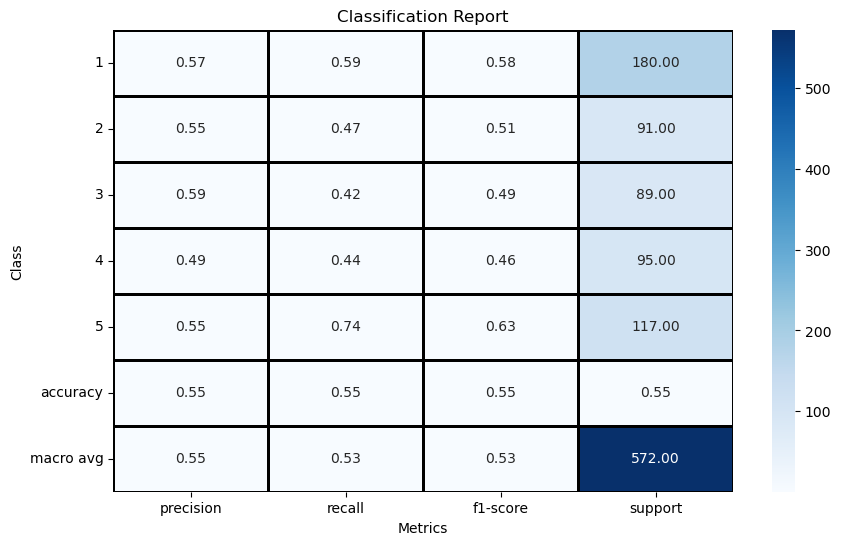

In [42]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generate the classification report as a dictionary
report = classification_report(y_test, rf.predict(X_test), output_dict=True)

# Convert the report into a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap with more definitive lines
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=True,
            linewidths=1, linecolor='black')  # Added linewidths and linecolor

# Set title and labels
plt.title('Classification Report')
plt.ylabel('Class')
plt.xlabel('Metrics')

# Save the plot as an image
plt.savefig('classification_report.png', dpi=300)

# Optionally display the plot
plt.show()


c:\Users\rschw\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


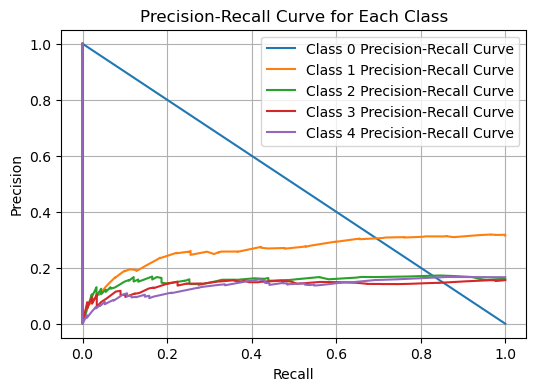

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for all classes
y_prob = rf.predict_proba(X_test)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(6, 4))

# Loop through each class and compute precision-recall curve
for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])  # OvR approach
    plt.plot(recall, precision, label=f'Class {i} Precision-Recall Curve')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid()
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],          # Number of trees in the forest.
    'max_depth': [None, 10, 20, 30],         
    'max_features': ['sqrt', 'log2'],       
    'bootstrap': [True, False]              
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_resampled, y_resampled) 
print(grid_search.best_estimator_) 

KeyboardInterrupt: 

In [ ]:
rf_model_best = RandomForestClassifier(max_features="log2",
                                    random_state=42,
                                    bootstrap=False) 
rf_model_best.fit(X_resampled, y_resampled) 

RandomForestClassifier(bootstrap=False, max_features='log2', random_state=42)

In [ ]:
print("Accuracy:", accuracy_score(y_train, rf_model_best.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, rf_model_best.predict(X_test)))


Accuracy: 1.0
Accuracy: 0.5472027972027972


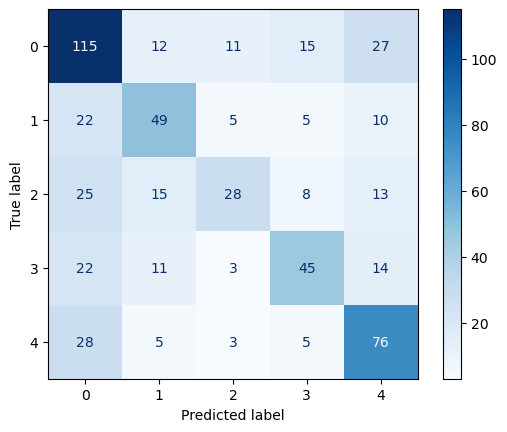

In [ ]:
cm_best = confusion_matrix(y_test, rf_model_best.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [ ]:
feature_importances = rf_model_best.feature_importances_
important = pd.DataFrame()
for name, importance in zip(X_train.columns, feature_importances):
    important = pd.concat([important, pd.DataFrame({'Name': [name], 'Importance': [importance]})], ignore_index=True)

important = important.sort_values(by='Importance', ascending=False)

In [ ]:
y_pred = rf_model_best.predict(X_test)
for a,b in zip(y_test,y_pred):
    print(f"True: {a}, Pred: {b}")

True: 1, Pred: 1
True: 4, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 1
True: 1, Pred: 5
True: 1, Pred: 1
True: 5, Pred: 1
True: 1, Pred: 5
True: 2, Pred: 2
True: 2, Pred: 2
True: 1, Pred: 3
True: 1, Pred: 1
True: 1, Pred: 1
True: 4, Pred: 4
True: 2, Pred: 2
True: 4, Pred: 4
True: 3, Pred: 2
True: 5, Pred: 1
True: 2, Pred: 5
True: 1, Pred: 1
True: 2, Pred: 1
True: 3, Pred: 3
True: 2, Pred: 5
True: 1, Pred: 1
True: 4, Pred: 4
True: 2, Pred: 2
True: 1, Pred: 1
True: 1, Pred: 5
True: 4, Pred: 3
True: 1, Pred: 5
True: 2, Pred: 2
True: 1, Pred: 1
True: 3, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 3
True: 1, Pred: 1
True: 1, Pred: 1
True: 2, Pred: 2
True: 2, Pred: 5
True: 3, Pred: 3
True: 5, Pred: 5
True: 4, Pred: 5
True: 3, Pred: 3
True: 1, Pred: 1
True: 3, Pred: 5
True: 3, Pred: 3
True: 2, Pred: 1
True: 5, Pred: 5
True: 1, Pred: 1
True: 4, Pred: 4
True: 5, Pred: 5
True: 5, Pred: 5
True: 1, Pred: 1
True: 3, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 4
True: 5, Pred: 5
True: 4, Pred: 4
True: 4, Pred:

In [ ]:
df[['gameId','playId','nflId','y','maxValueOfSeparation']][(df['gameId']==2022091805)&(df['playId']==2207)].sort_values(by='y', ascending=False)

,gameId,playId,nflId,y,maxValueOfSeparation
6075,2022091805,2207,53449,41.28,111.649976
5948,2022091805,2207,43329,32.47,57.682761
5980,2022091805,2207,46071,21.07,62.509320
6230,2022091805,2207,54577,18.68,241.383681
6041,2022091805,2207,48489,11.96,57.897364


In [ ]:
y_test.head(10)

1583    1
1745    4
772     5
1728    1
387     1
407     1
2293    5
1991    1
2447    2
2754    2
Name: maxSeparationReceiver, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

In [ ]:
one.iloc[1745]

gameId                    2022091805
playId                          2207
down                               1
yardsToGo                         10
offenseFormation             SHOTGUN
pff_passCoverage            Quarters
absoluteYardlineNumber            26
receiverAlignment                2x2
firstY                         41.28
secondY                        32.47
thirdY                         21.07
fourthY                        18.68
fifthY                         11.96
sixthY                             0
firstRoute                        GO
secondRoute                       GO
thirdRoute                     WHEEL
fourthRoute                       GO
fifthRoute                     HITCH
safetyTop                        1.0
safetyBottom                     2.0
rbPosition                         3
aboveLine                          2
belowLine                          2
motionReceiver                     2
motionCluster                    5.0
inMotionAtBallSnap             False
t

XGBoost

In [ ]:
y = y.cat.codes

In [ ]:
X = pd.get_dummies(X, columns=['down','offenseFormation','rbPosition','pff_passCoverage','motionReceiver','motionCluster', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [ ]:
bool_cols = ['yardsToGo', 'absoluteYardlineNumber', 'fifthY', 'aboveLine', 'belowLine', 'inMotionAtBallSnap']  # Add other boolean columns as needed
X[bool_cols] = X[bool_cols].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
class_counts = y_train.value_counts()
scale_pos_weight = class_counts.max() / class_counts.min()

In [ ]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_train, y_train)

c:\Users\rschw\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Testing Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Testing Accuracy: 0.96
Testing Accuracy: 0.53


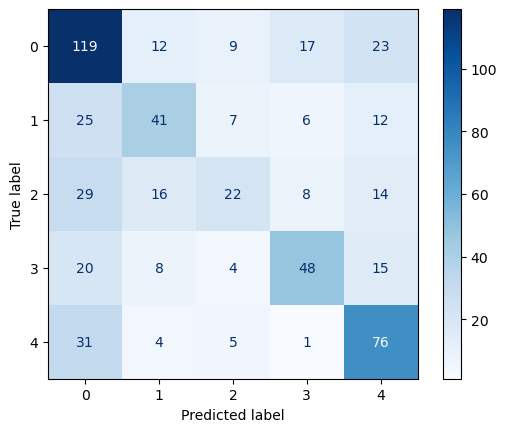

In [ ]:
cm_best = confusion_matrix(y_test, model.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_resampled, y_resampled)

c:\Users\rschw\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Testing Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Testing Accuracy: 0.94
Testing Accuracy: 0.53
